# Session 13: Mixtures of Bernoulli distributions

------------------------------------------------------
*Introduction to Data Science & Machine Learning*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------


In this notebook we will implement the EM algorithm for mixtures of Bernoulli distributions. This model is also known as [*latent class analysis*](https://en.wikipedia.org/wiki/Latent_class_model). As well as being of practical importance on its own right, understading this model and its learning also lay the fundation for **hidden Markov models (HMMs)** over discrete variables. HMMs will be dicussed in future course sessions.



### Mixtures of Bernoulli distributions

Consider a set of i.i.d. $D$-dimensional binary (0-1) vectors. Examples of this kind of data are binary images, binary detection results, or genetic markers. Consider also a mixture of multinomials (or multivariate Bernoullis) model for each of the vectors, $\mathbf{x}$,

$$\displaystyle p(\mathbf{x} | \boldsymbol{\Theta},\mathbf{\pi} ) = \sum_{k=1}^K \pi_k p_k(\mathbf{x}^{(i)}|\boldsymbol{\theta}_k) = \sum_{k=1}^K \pi_k \prod_{j=1}^D \theta_{jk}^{x_{j}} (1-\theta_{jk})^{1-x_{j}},$$
where $\boldsymbol{\Theta}=[\boldsymbol{\theta}_1,\ldots,\boldsymbol{\theta}_K]$. If we are given a data set $\mathbf{X}=\{\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)}\}$ then the log likelihood function for this model is given by

\begin{align}
\log p(\mathbf{X}|\boldsymbol{\Theta},\mathbf{\pi}) = \sum_{i=1}^N \log\left(\sum_{k=1}^D \pi_k p(\mathbf{x}^{(i)}|\boldsymbol{\theta}_k)\right)
\end{align}

To prevent overfitting, we will also use a **prior distribution** for the model parameters. For $\boldsymbol{\Theta}$ we have

\begin{align}
\theta_{jk}&\sim\text{Beta}(\alpha,\beta)\\
p(\boldsymbol{\Theta}) &= \prod_{k=1}^{K} \prod_{j=1}^D p(\theta_{jk})\\
p(\theta_{jk}) &= \frac{\theta_{jk}^{\alpha-1}(1-\theta_{jk})^{\beta-1}}{\text{B}(\alpha,\beta)},
\end{align}
where $\text{B}(\alpha,\beta)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function). Check [here](https://en.wikipedia.org/wiki/Beta_distribution) for more details about the Beta distribution.

For $\mathbf{\pi}$ we use a uniform [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution):
\begin{align}
\mathbf{\pi}&\sim \text{Dir}(\frac{1}{K}, \ldots, \frac{1}{K}) \Rightarrow p(\mathbf{\pi}) =\frac{1}{\text{B}(\frac{1}{K}, \ldots, \frac{1}{K})}\prod_{k=1}^{K}\pi_k^{\frac{1}{K}-1},
\end{align}
where $\text{B}(\frac{1}{K}, \ldots, \frac{1}{K})$ is the multivariate Beta function.


### EM learning

We now derive the EM algorithm for maximizing the posterior distribution $p(\mathbf{\Theta},\mathbf{\pi}|\mathbf{X})$. To do this, we introduce an explict discrete latent variable $z\in\{1,\ldots,K\}$ assoacted to each data point $\mathbf{x}$:
\begin{align}
p(\mathbf{x},z) = \prod_{k=1}^{K} \left(\pi_k ~p_{k}(\mathbf{x})\right)^{\mathbb{1} [z==k]}, ~~ p(z)=\prod_{k=1}^K \pi_k^{\mathbb{1} [z==k]}
\end{align}

#### Complete log-likelihood

We write the complete data log-likelihood as follows:
\begin{align}
\log p(\mathbf{X},\mathbf{z}|\boldsymbol{\Theta},\mathbf{\pi})=\sum_{i=1}^{N}\sum_{k=1}^{K}\mathbb{1} [z^{(i)}==k]\left(\log \pi_k + \sum_{j=1}^D \left[x_{j}^{(i)}\log\theta_k+(1-x_{j}^{(i)})\log(1-\theta_k)\right]\right)
\end{align}

#### Posterior distribution of $\mathbf{z}$ given $\boldsymbol{\Theta},\mathbf{\pi}$

In the $E$, we compute the expected complete data log-likelihood w.r.t. posterior distribution of $\mathbf{z}$ given the current values of $\boldsymbol{\Theta},\mathbf{\pi}$:
\begin{align}
p(z^{(i)}=k|\mathbf{x}^{(i)},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)}) \triangleq r_{ik} = \frac{\pi_{(k,t-1)} p_k(\mathbf{x}|\boldsymbol{\theta}_k) }{\sum_{q=1}^K \pi_{(q,t-1)} p_k(\mathbf{x}^{(i)}|\boldsymbol{\theta}_q)}, ~~~ k=1,\ldots, K
\end{align}

#### E-step
It is easy to show that
\begin{align}
\mathcal{Q}(\boldsymbol{\Theta},\mathbf{\pi},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})&=\mathbb{E}_{p(\mathbf{z}|\mathbf{X}^{(i)},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})}[\log p(\mathbf{X},\mathbf{z}|\boldsymbol{\Theta},\mathbf{\pi})]\\
&=\sum_{i=1}^{N}\sum_{k=1}^K r_{ik} \left(\log \pi_k + \sum_{j=1}^D \left[x_{j}^{(i)}\log\theta_k+(1-x_{j}^{(i)})\log(1-\theta_k)\right]\right)
\end{align}

#### M-step

We have to find
\begin{align}
\boldsymbol{\Theta}_t,\mathbf{\pi}_t = \arg \max_{\boldsymbol{\Theta},\mathbf{\pi}} ~~\mathcal{Q}(\boldsymbol{\Theta},\mathbf{\pi},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})+ \log p(\boldsymbol{\Theta})+\log p(\mathbf{\pi})
\end{align}

As a result, one can prove that the maximum is attained at

\begin{align}
r_k &\triangleq \sum_{i=1}^N r_{ik} \\\\
\pi^t_k &= \frac{r_k+\frac{1}{K}-1}{N+1-K}\\\\
\boldsymbol{\theta}_k &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}+\alpha-1}{r_k+\alpha+\beta-2} 
\end{align}

To see details about the derivation of this result, check out chapter 9 of Bishop's book. Also Chapter 11 of Murphy's book.

## Implementation of the E-step

We first write a Python function that evaluates the responsibilities $r_{ik}$, $i=1,\ldots,N$, $k=1,\ldots,K$ for each data point. It should take as input the current values of $\boldsymbol{\pi}$, $\boldsymbol{\Theta}$, and the matrix $\mathbf{X}$ of observations.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

In [3]:

# THE FOLLOWING FUNCTION takes the whole matrix of data points and the vector 
# of probabilites of a single cluster. The function returns the probability of each data 
# point given cluster parameters p(x|theta_k)

def eval_bern_pdf(X,Thetak):
    #Your code here
    M = np.exp(X*np.log(Thetak)+(1-X)*np.log(1-Thetak)) 
    pmf = np.prod(M,1)
    return pmf


# THE FOLLOWING FUNCTION takes the whole matrix of data points, the vector 
# of probabilites of a single cluster and the cluster probabilites. The function  returns 
# the matrix of responsibilites

def responsibilities(X,P,Theta,K):
    N,D = X.shape
    R = np.zeros([N,K])
    
    for k in range(K):
        #Your code here
        
        R[:,k] = eval_bern_pdf(X,Theta[k,:])
        
        
    R *= P.T
    R /= np.sum(R,1).reshape([-1,1])    
    
    return R
        

In [4]:
#We test the code with the following example

N = 2
D = 5
K = 3

np.random.seed(10)

X = np.random.randint(0,2,[N,D])
Theta = np.random.rand(K,D)

print(Theta)

P = np.random.rand(K,1)
P /= np.sum(P)

print(P)

R = responsibilities(X,P,Theta,K)

# R should be a [N,K] matrix with the following values
# [[  2.20811374e-02   2.19873976e-01   7.58044887e-01]
#  [  7.49839314e-04   3.34167429e-01   6.65082732e-01]]

print(X)

print(R)

[[0.22479665 0.19806286 0.76053071 0.16911084 0.08833981]
 [0.68535982 0.95339335 0.00394827 0.51219226 0.81262096]
 [0.61252607 0.72175532 0.29187607 0.91777412 0.71457578]]
[[0.51277512]
 [0.13436922]
 [0.35285566]]
[[1 1 0 1 0]
 [1 1 0 1 1]]
[[2.20811374e-02 2.19873976e-01 7.58044887e-01]
 [7.49839314e-04 3.34167429e-01 6.65082732e-01]]


## Implementation of the M step

In [5]:
# THE FOLLOWING FUNCTION computes the the soft number of points 
# associated to each cluster given the matrix R

def points_cluster(R):
    #Your code here
    return np.sum(R,0)

# THE FOLLOWING FUNCTION updates the value of the cluster probabilites

def new_P(R,N):
    #Your code here
    Rk = points_cluster(R)
    return Rk/N

def new_Theta(R,X,K,alpha,beta):
    
    Theta = np.zeros([K,D])
    Rk = points_cluster(R)
    
    for k in range(K):
        #Your code here
        Theta[k,:] = (np.sum(X*R[:,k].reshape([-1,1]),0)+alpha-1) / (Rk[k]+alpha+beta-2)
    
    return Theta



In [6]:
alpha = 2.
beta = 2.

Theta = new_Theta(R,X,K,alpha,beta)

print(Theta)

# Theta should be a [K,D] matrix with the following values
# [[ 0.50564332  0.50564332  0.49435668  0.50564332  0.49472737]
# [ 0.60846367  0.60846367  0.39153633  0.60846367  0.52237502]
#  [ 0.70786949  0.70786949  0.29213051  0.70786949  0.48642146]]



[[0.50564332 0.50564332 0.49435668 0.50564332 0.49472737]
 [0.60846367 0.60846367 0.39153633 0.60846367 0.52237502]
 [0.70786949 0.70786949 0.29213051 0.70786949 0.48642146]]


## Computing the log-likelihood

In [7]:
# THE FOLLOWING FUNCTION computes the model log-likelihood 
# given the model parameters

def log_lik(X,P,Theta,K):
    
    LL = 0.
    
    for k in range(K):
        #Your code here
        LL += eval_bern_pdf(X,Theta[k,:])*P[k]
        
    return np.sum(np.log(LL)) #Your code here


In [8]:
#For the toy example the LL should be -5.31111037373

print(log_lik(X,P,Theta,K))

-5.311110373732397


## EM for a synthetic dataset

Let's generate samples from a mixtures of Bernoulli distributions and run the EM algorithm to recover the true model parameters.

In [9]:
## True model parameters
K = 5
D = 100
N = 5000
X = []


Theta_true = np.random.rand(K,D)
P_true = np.random.rand(K,1)
P_true /= np.sum(P_true)

N_Z_true = np.random.multinomial(N,P_true.reshape([-1,]))

for k in range(K):
    X.append(np.random.rand(N_Z_true[k],D)<=Theta_true[k,:])
    print(X[k].shape)

X = np.concatenate(X)

(443, 100)
(1445, 100)
(973, 100)
(1135, 100)
(1004, 100)


In [20]:
## EM initialization
K = 5

P = np.random.rand(K,1)
P /= np.sum(P_true)

Theta = 0.5/K*np.ones([K,D])+0.5*np.random.rand(K,D)   # This initialization ensures all clusters begin with
                                                       # non-negligible probability

Num_Iter = 500

alpha = 2.1
beta = 2.1

LL = np.zeros([Num_Iter,1])

for i in range(Num_Iter):
    
    LL[i] = log_lik(X,P,Theta,K)
    
    R = responsibilities(X,P,Theta,K)
    
    P = new_P(R,N)
    
    Theta = new_Theta(R,X,K,alpha,beta)
    

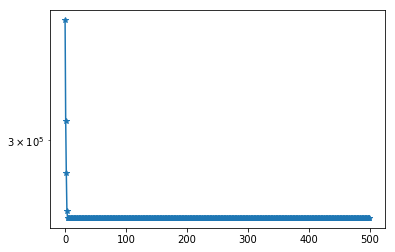

In [21]:
# Plot the evolution of the negative LL. It should always decrease!

plt.semilogy(-LL,'-*')  

Text(0.5,1,'Cluster Probabilites')

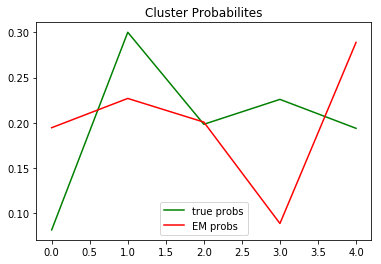

In [22]:
plt.plot(P_true,label='true probs', color = [0, 0.5, 0])
plt.plot(P,label='EM probs', color = [1, 0, 0])
plt.legend()
plt.title('Cluster Probabilites')

## EM for a data set of handwritten digits

Load and run the EM over the [sklearn dataset of digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits). Each datapoint is a 8x8 image of a digit.

(1797, 64)


<Figure size 432x288 with 0 Axes>

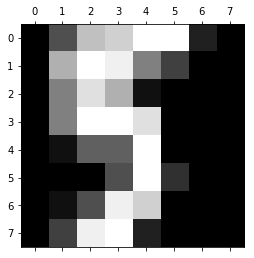

<Figure size 432x288 with 0 Axes>

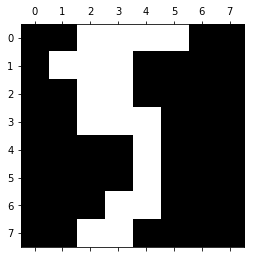

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()    #Gray scale, we have to binarize
print(digits.data.shape)

plt.gray() 
plt.matshow(digits.images[15]) 
plt.show()

#Binarization

Bin_Images = np.copy(digits.images)

val_min=np.min(Bin_Images)
val_max=np.max(Bin_Images)

Bin_Images = (Bin_Images - val_min) / (val_max - val_min)

Bin_Images = np.round(Bin_Images)

plt.gray() 
plt.matshow(Bin_Images[15]) 
plt.show()


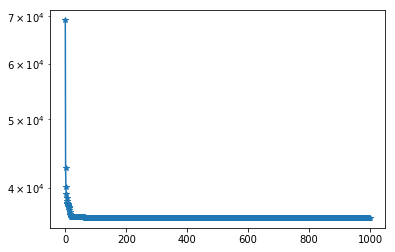

In [24]:
# EM 

K = 10
D = 64
X = Bin_Images.reshape([-1,D])

P = np.random.rand(K,1)
P /= np.sum(P_true)


Theta = 0.5/K*np.ones([K,D])+0.5*np.random.rand(K,D)   # This initialization ensures all clusters begin with
                                                       # non-negligible probability

Num_Iter = 1000

alpha = 2.
beta = 2.

LL = np.zeros([Num_Iter,1])

for i in range(Num_Iter):
    
    LL[i] = log_lik(X,P,Theta,K)
    
    R = responsibilities(X,P,Theta,K)
    
    P = new_P(R,N)
    
    Theta = new_Theta(R,X,K,alpha,beta)
    

# Plot the evolution of the negative LL. It should always decrease!
plt.semilogy(-LL,'-*')  


<Figure size 432x288 with 0 Axes>

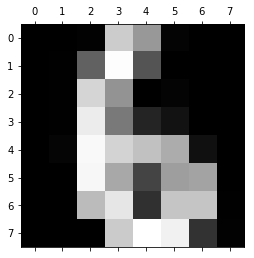

<Figure size 432x288 with 0 Axes>

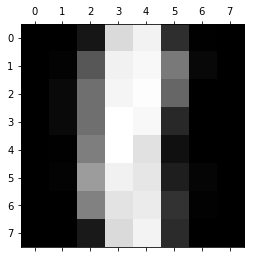

<Figure size 432x288 with 0 Axes>

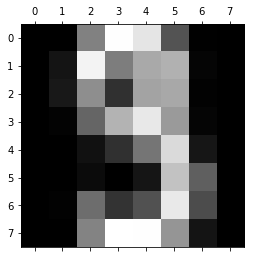

<Figure size 432x288 with 0 Axes>

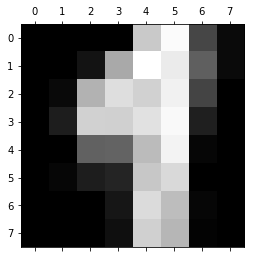

<Figure size 432x288 with 0 Axes>

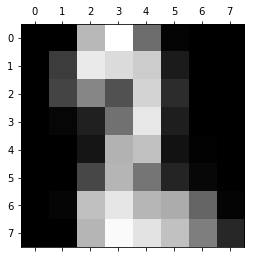

<Figure size 432x288 with 0 Axes>

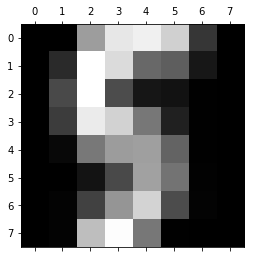

<Figure size 432x288 with 0 Axes>

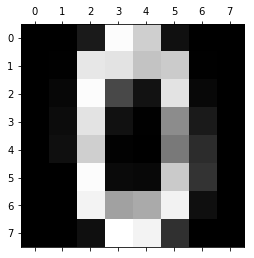

<Figure size 432x288 with 0 Axes>

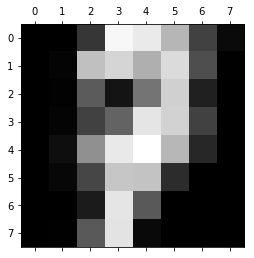

<Figure size 432x288 with 0 Axes>

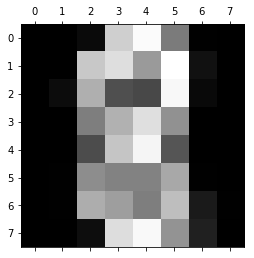

<Figure size 432x288 with 0 Axes>

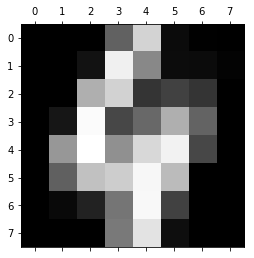

In [25]:
# Plot as a 8x8 gray-scale image each theta_k vector
# (it represents the probability of each pixel to take value 1)


for k in range(K):
    plt.gray() 
    plt.matshow(Theta[k,:].reshape([8,8])) 
    plt.show()

## EM for the MNIST Database 

Repeat the experiment for the MNIST Database. Take $10^4$ images **at random**, and binarize the database.


In [26]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

<Figure size 432x288 with 0 Axes>

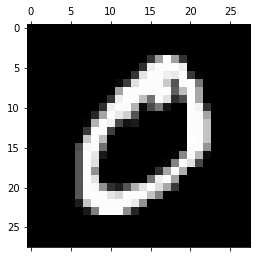

<Figure size 432x288 with 0 Axes>

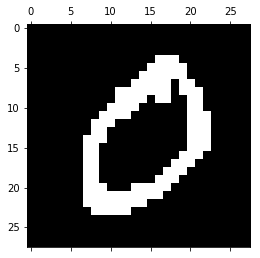

In [27]:
images = mnist.data  #70000 images


plt.gray() 
plt.matshow(images[0,:].reshape([28,28])) 
plt.show()

val_min=np.min(images)
val_max=np.max(images)

Bin_Images = (images - val_min) / (val_max - val_min)

Bin_Images = np.round(Bin_Images)

plt.gray() 
plt.matshow(Bin_Images[0,:].reshape([28,28])) 
plt.show()

mask = np.random.permutation(Bin_Images.shape[0])

Bin_Images = Bin_Images[mask,:]

In [28]:
# EM 

K = 10
D = 784
N = 1000

X = Bin_Images[:N,:]

P = np.random.rand(K,1)
P /= np.sum(P_true)

Theta = 0.5/K*np.ones([K,D])+0.5*np.random.rand(K,D)

Num_Iter = 1000

alpha = 2.1
beta = 2.1

LL = np.zeros([Num_Iter,1])

for i in range(Num_Iter):
    
    LL[i] = log_lik(X,P,Theta,K)
    
    R = responsibilities(X,P,Theta,K)
    
    P = new_P(R,N)
    
    Theta = new_Theta(R,X,K,alpha,beta)
    
    if(i % 20 ==0):
        print('Iteration ',i)
    

Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Iteration  500
Iteration  520
Iteration  540
Iteration  560
Iteration  580
Iteration  600
Iteration  620
Iteration  640
Iteration  660
Iteration  680
Iteration  700
Iteration  720
Iteration  740
Iteration  760
Iteration  780
Iteration  800
Iteration  820
Iteration  840
Iteration  860
Iteration  880
Iteration  900
Iteration  920
Iteration  940
Iteration  960
Iteration  980


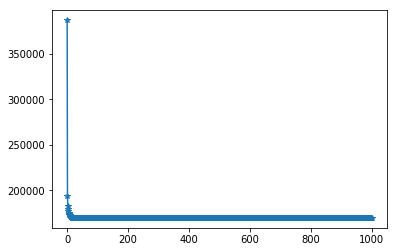

In [29]:
# Plot the evolution of the negative LL. It should always decrease!
plt.plot(-LL,'-*')  

<Figure size 432x288 with 0 Axes>

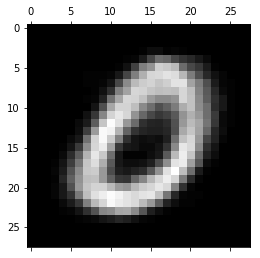

<Figure size 432x288 with 0 Axes>

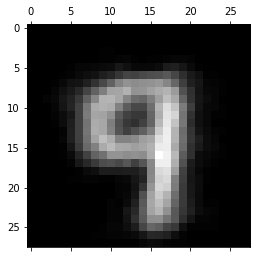

<Figure size 432x288 with 0 Axes>

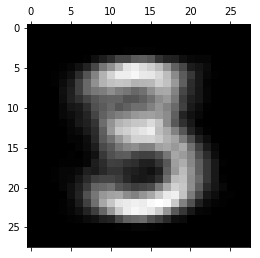

<Figure size 432x288 with 0 Axes>

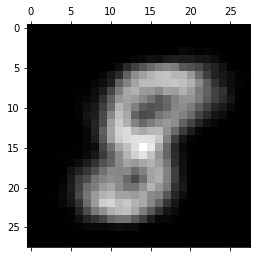

<Figure size 432x288 with 0 Axes>

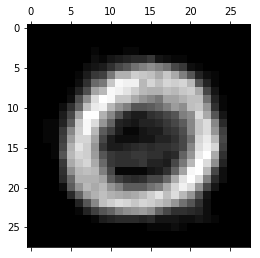

<Figure size 432x288 with 0 Axes>

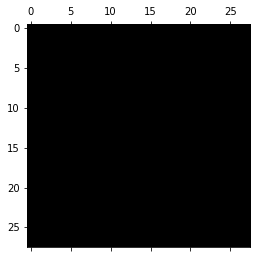

<Figure size 432x288 with 0 Axes>

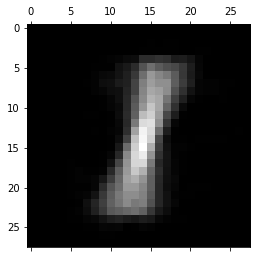

<Figure size 432x288 with 0 Axes>

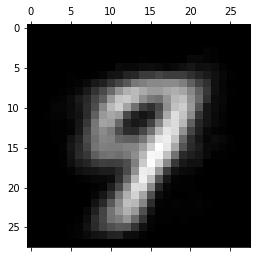

<Figure size 432x288 with 0 Axes>

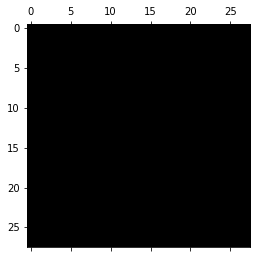

<Figure size 432x288 with 0 Axes>

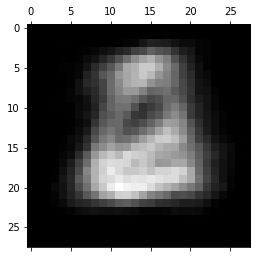

In [30]:
# Plot as a 8x8 gray-scale image each theta_k vector
# (it represents the probability of each pixel to take value 1)


for k in range(K):
    plt.gray() 
    plt.matshow(Theta[k,:].reshape([28,28])) 
    plt.show()